##### 【 ML - 생선 분류 모델 만들기 】

- 주__제 : 2개 종류 생선 분류 모델 만들기
- 학습종류: 지도학습 -> 분류
- 학습방법: 다양한 분류 알고리즘들 => KNN 최근접이웃알고리즘

- 데이터셋
    * 학습용 데이터셋
        - 모델 학습에 즉, 데이터의 규칙과 패턴 찾기위해서 사용되는 데이터셋

    * 검증용 데이터셋
        - 모델 학습 중 제대로 규칙과 패턴 찾고 있는지 검사하기 위한 데이터셋
        - scikit-learn은 fit()메서드로 학습 종료되어서 사용 할 수 없음
        - 교차검증, 일부 학습 알고리즘에서는 사용 가능

    * 테스트용 데이터셋
        - 학습 완료 후 성능검사에 사용되는 데이터셋
        - 추가 학습 진행 여부 결정 기준이 됨!
        - ★절대 학습에 사용되면 안됨!!★

[1] 데이터 확인 : 피쳐와 타겟 <hr>

In [1]:
## [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

## ML 학습알고리즘 모델
from sklearn.neighbors import KNeighborsClassifier
## 데이터셋 관련
from sklearn.model_selection import train_test_split

In [2]:
## CoW 기능 활성화 : 데이터 변경시 복사 후 처리
if not pd.get_option('copy_on_write'):
    pd.options.mode.copy_on_write = True
    print(f"CoW : {pd.get_option('copy_on_write')}")

CoW : True


In [4]:
## [1-2] 데이터 로딩 및 빙어와도미 데이터만 추출
DATA_FILE='../Data/fish.csv'

## 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE, usecols=[0,1,2])
#display(allDF.head(3))

## Bream 도미, Smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

## 행인덱스 초기화
fishDF.reset_index(drop=True, inplace=True)
#display(fishDF.head(3), fishDF.tail(3))
#fishDF.info()

In [5]:
## [1-3] 무게와 길이 피쳐와 품종 분류 가능 여부
# pd.set_option('future.no_silent_downcasting', True)
# fishDF.loc[:, 'Species'] = fishDF.loc[:, 'Species'].replace({'Bream':0, 'Smelt':1})
# fishDF.Species = fishDF.Species.astype('category')
# fishDF.Species


In [5]:
## 품종 컬럼 타입 변환 저장
speciesSR = fishDF.Species
fishDF.Species=speciesSR.astype('category')
## 전체 데이터 타입 확인
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  49 non-null     category
 1   Weight   49 non-null     float64 
 2   Length   49 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 1.1 KB


In [6]:
## 카테고리 접근자 cat 사용
print(f'[categories] => {fishDF.Species.cat.categories}')
print(f'[codes]      =>\n{fishDF.Species.cat.codes}')

[categories] => Index(['Bream', 'Smelt'], dtype='object')
[codes]      =>
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
dtype: int8


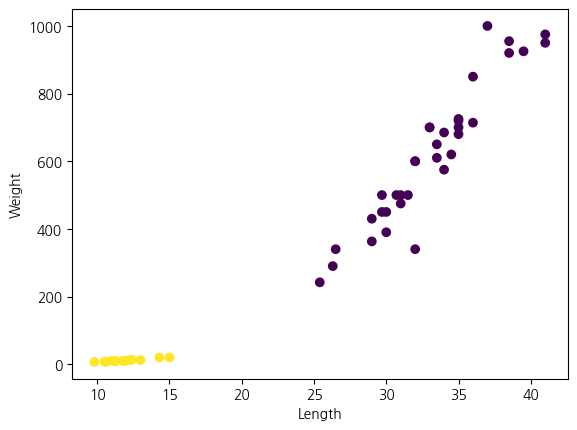

,Weight,Length
Weight,1.000000,0.960347
Length,0.960347,1.000000


In [7]:
## - 시각화 : 산점도 => 색상을 품종에따라 다르게 설정 c 매개변수
plt.scatter(fishDF.Length, fishDF.Weight, c=fishDF.Species.cat.codes )
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

## - 상관계수
fishDF.corr(numeric_only=True)


[2] 피쳐/데이터와 타겟/라벨 분리<hr>

In [ ]:
## 학습용 피쳐/데이터와 타겟/라벨 분리
## -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

## -> 타겟/라벨 : 1D
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR  : {targetSR.shape} / {targetSR.ndim}D')



featureDF : (49, 2) / 2D,  targetSR : (49,) / 1D  


[3] 학습용, 테스트용 데이터셋 분리 <hr>
- 일반적 : 학습용 : 테스트용 = 8 : 2
- 수집된 데이터에 따라서 학습용 데이터셋 비율 설정
- scikit-learn 기본값 => 7.5 : 2.5

In [ ]:
## train_test_split(2D피쳐, 1D타겟, ....) => 반환 4개 원소 튜플
train_test_split

[3] 학습 진행<hr>
- 학습 알고리즘의 기본 설정값 그대로 학습 진행 => 성능 점수 : 베이스 점수 / 최저 점수 / 기준 점수
- 성능 향상 위한 하이퍼파라미터 튜닝 진행 => 학습 알고리즘별 하이퍼파라미터 체크

In [ ]:
scoreList = []
## 최적 성능의 k 즉, n_neighbors 찾기
for k  in range(1, fishDF.shape[0]+1):
    ##- 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k)

    ##- 모델 학습
    kModel.fit(featureDF, targetSR)

    ##- 모델 성능평가
    score = kModel.score(featureDF, targetSR)
    print(f'[{k}]  score : {score:.6f}')
    scoreList.append(score)

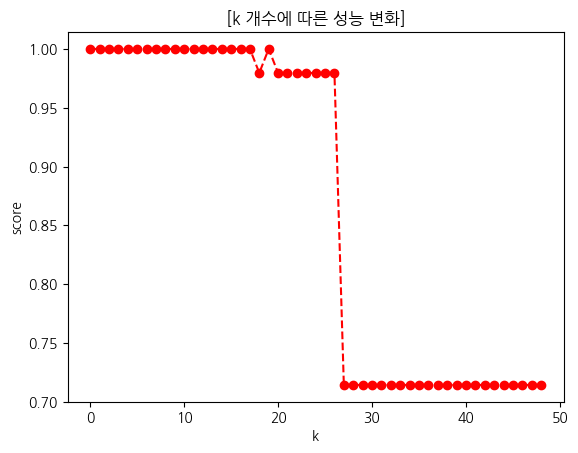

In [17]:
##- k 개수에 따른 점수 시각화
plt.plot(scoreList, 'ro--')
plt.xlabel('k')
plt.ylabel('score')
plt.title('[k 개수에 따른 성능 변화]')
plt.show()

[4] 평가진행 : 테스트용 데이터/피쳐와  타겟<hr>
- 학습용 데이터 평가결과 테스트용 데이터 평가결과 비교

In [12]:
kModel.score(featureDF, targetSR)

1.0

[5] 모델 활용 서비스<hr>

In [13]:
## 아무 도미 또는 빙어의 길이/무게 ==> 도미와 빙어 예측
#in_data = input("생선의 무게, 길이 입력(예:120 23):").strip().split()
#in_data = [ float(data)  for data in in_data ]
#in_data  = list(map(float, in_data))
in_data = [236.5, 4.1]
new_data = pd.DataFrame([in_data] , columns=fishDF.columns[1:])

kModel.predict(new_data)

array(['Bream'], dtype=object)